## Inicialización

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

## Cargar datos

El conjunto de datos se almacena en la carpeta `/datasets/faces/`
- La carpeta `final_files` con 7600 fotos
- El archivo `labels.csv` con leyendas, con dos columnas: `file_name` y `real_age`

Dado que el número de archivos de imágenes es bastante elevado, se recomienda evitar leerlos todos a la vez, ya que esto consumiría muchos recursos computacionales. Te recomendamos crear un generador con ImageDataGenerator. Este método se explicó en el capítulo 3, lección 7 de este curso.

El archivo de etiqueta se puede cargar como un archivo CSV habitual.

In [5]:
labels = pd.read_csv('/datasets/faces/labels.csv')

train_datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


## EDA

In [3]:
labels.sample(10)

,file_name,real_age
2104,002104.jpg,29
1931,001931.jpg,43
5427,005427.jpg,20
5537,005537.jpg,49
5829,005829.jpg,57
7247,007265.jpg,50
7029,007041.jpg,50
3452,003452.jpg,24
1702,001702.jpg,38
2198,002198.jpg,49


In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [6]:
# Contar valores nulos en la base de datos de imágenes
null_count = labels['real_age'].isnull().sum()
print("Cantidad de valores nulos en la base de datos:", null_count)

Cantidad de valores nulos en la base de datos: 0


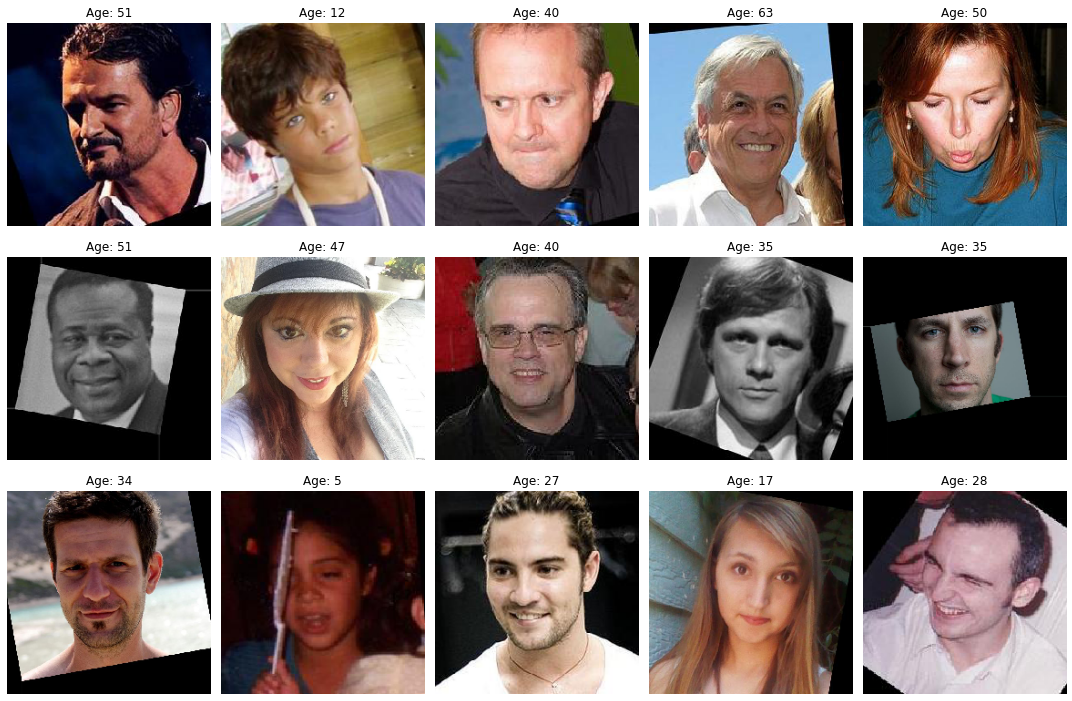

In [9]:
# Obtener un lote de imágenes y sus etiquetas
images, ages = next(train_gen_flow)

# Mostrar 10 a 15 imágenes
fig, axes = plt.subplots(3, 5, figsize=(15, 10))

for i, ax in enumerate(axes.flatten()):
    # Mostrar la imagen
    ax.imshow(images[i])
    ax.set_title(f"Age: {ages[i]}")
    ax.axis('off')
    
    # Salir del bucle cuando se han mostrado entre 10 y 15 imágenes
    if i == 14:
        break

plt.tight_layout()
plt.show()

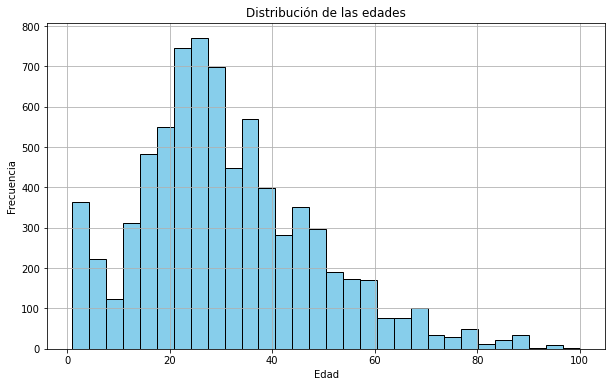

In [6]:
# Graficar la distribución de las edades
plt.figure(figsize=(10, 6))
plt.hist(labels['real_age'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribución de las edades')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

### Conclusiones

<div class="alert alert-info"> <b>Comentario del estudiante CORREGIDO:</b> Como podemos apreciar la base de datos que nos comparten no tiene valores nulos, si me llama la atencion que en la descripcion dice que son 7600 fotos, cuando realmente son 7591 entradas las que hay disponibles, claro esto no deberia afectar el resultado, tambien pudimos observar que no hay un numero igual de imagenes para cada grupo de edad. Tenemos mas data en el grupo de edad entre los 20-40 años, lo cual volvera el modelo mas experto reconociendo personas en ese rango de edad.

Viendo como esta compuesta la base de datos de imagenes, deberia ser suficientemente facil completar lo que se pide, ya que hay bastante informacion visual valiosa en ella, ademas de la relacion que existe con su edad, con esto deberia poder trabajar sin mucho inconveniente, aunque podemos prever que con esta base de datos el resultado final probablemente no sera el deseado, por falta de mas imagenes para los demas rangos de edad.</div>

## Modelado

Define las funciones necesarias para entrenar tu modelo en la plataforma GPU y crear un solo script que las contenga todas junto con la sección de inicialización.

Para facilitar esta tarea, puedes definirlas en este notebook y ejecutar un código listo en la siguiente sección para componer automáticamente el script.

Los revisores del proyecto también verificarán las definiciones a continuación, para que puedan comprender cómo construiste el modelo.

In [10]:
def load_train(path):
    """
    Carga la parte de entrenamiento del conjunto de datos desde la ruta.
    """
    train_datagen = ImageDataGenerator(rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'),
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345
    )
    return train_gen_flow

In [11]:
def load_test(path):
    """
    Carga la parte de validación/prueba del conjunto de datos desde la ruta.
    """
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'),
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345
    )
    return test_gen_flow

In [12]:
def create_model(input_shape):
    """
    Define el modelo.
    """
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(1)
    ])
    return model

<div class="alert alert-info"> <b>Comentario del estudiante:</b> Esta actualizacion la pasaremos por alto por lo menos dentro del proyecto, ya que al final no hay forma con esto de lograr que el modelo tenga un margen de error inferior a 1 año que seria lo adecuado para el trabajo que se pide, y asi evitar problemas legales al supermercado, por eso en las conclusiones hacemos una recomendacion de uso bastante diferentes, gracias de antemano por la sugerencia .</div>

In [13]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
    """
    Entrena el modelo dados los parámetros.
    """
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    history = model.fit(
        train_data,
        epochs=epochs,
        validation_data=test_data,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps
    )
    return model

### Prepara el script para ejecutarlo en la plataforma GPU

Una vez que hayas definido las funciones necesarias, puedes redactar un script para la plataforma GPU, descargarlo a través del menú "File|Open..." (Archivo|Abrir) y cargarlo más tarde para ejecutarlo en la plataforma GPU.

Nota: el script debe incluir también la sección de inicialización. A continuación se muestra un ejemplo.

In [14]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:

    f.write(init_str)
    f.write('\n\n')

    for fn_name in [load_train, load_test, create_model, train_model]:

        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Resultado

Coloca aquí el resultado de la plataforma GPU como una celda Markdown.

In [15]:
# %% [markdown]
# 2023-04-10 04:41:07.285193: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
# 2023-04-10 04:41:07.338398: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
# Using TensorFlow backend.
# Found 5694 validated image filenames.
# Found 1897 validated image filenames.
# 2023-04-10 04:41:10.212230: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
# 2023-04-10 04:41:10.291251: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
# 2023-04-10 04:41:10.291450: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties:
# pciBusID: 0000:00:1e.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
# coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
# 2023-04-10 04:41:10.291485: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
# 2023-04-10 04:41:10.291529: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
# 2023-04-10 04:41:10.344041: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
# 2023-04-10 04:41:10.354479: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
# 2023-04-10 04:41:10.459874: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
# 2023-04-10 04:41:10.470656: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
# 2023-04-10 04:41:10.470711: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
# 2023-04-10 04:41:10.470806: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
# 2023-04-10 04:41:10.471008: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
# 2023-04-10 04:41:10.471142: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
# 2023-04-10 04:41:10.471507: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
# 2023-04-10 04:41:10.494886: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300010000 Hz
# 2023-04-10 04:41:10.496657: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x3a2ff60 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
# 2023-04-10 04:41:10.496684: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
# 2023-04-10 04:41:10.623815: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
# 2023-04-10 04:41:10.624124: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x25127c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
# 2023-04-10 04:41:10.624147: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-16GB, Compute Capability 7.0
# 2023-04-10 04:41:10.624376: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
# 2023-04-10 04:41:10.624565: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties:
# pciBusID: 0000:00:1e.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
# coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
# 2023-04-10 04:41:10.624616: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
# 2023-04-10 04:41:10.624629: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
# 2023-04-10 04:41:10.624662: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
# 2023-04-10 04:41:10.624691: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
# 2023-04-10 04:41:10.624721: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
# 2023-04-10 04:41:10.624738: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
# 2023-04-10 04:41:10.624747: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
# 2023-04-10 04:41:10.624843: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
# 2023-04-10 04:41:10.625084: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
# 2023-04-10 04:41:10.625219: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
# 2023-04-10 04:41:10.626315: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
# 2023-04-10 04:41:11.840376: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
# 2023-04-10 04:41:11.840428: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0
# 2023-04-10 04:41:11.840438: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N
# 2023-04-10 04:41:11.841791: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
# 2023-04-10 04:41:11.842068: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
# 2023-04-10 04:41:11.842246: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
# 2023-04-10 04:41:11.842289: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 14988 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:1e.0, compute capability: 7.0)
# Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
# 
#     8192/94765736 [..............................] - ETA: 1s
# 11714560/94765736 [==>...........................] - ETA: 0s
# 24510464/94765736 [======>.......................] - ETA: 0s
# 37552128/94765736 [==========>...................] - ETA: 0s
# 50290688/94765736 [==============>...............] - ETA: 0s
# 62988288/94765736 [==================>...........] - ETA: 0s
# 75726848/94765736 [======================>.......] - ETA: 0s
# 88399872/94765736 [==========================>...] - ETA: 0s
# 94773248/94765736 [==============================] - 0s 0us/step
# <class 'tensorflow.python.keras.engine.sequential.Sequential'>
# WARNING:tensorflow:sample_weight modes were coerced from
#   ...
#     to
#   ['...']
# WARNING:tensorflow:sample_weight modes were coerced from
#   ...
#     to
#   ['...']
# Train for 356 steps, validate for 119 steps
# Epoch 1/20
# 2023-04-10 04:41:26.034305: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
# 2023-04-10 04:41:26.762342: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
# 356/356 - 54s - loss: 240.1997 - mae: 11.0967 - val_loss: 424.1841 - val_mae: 15.4917
# Epoch 2/20
# 356/356 - 38s - loss: 73.1405 - mae: 6.5176 - val_loss: 130.2860 - val_mae: 8.9525
# Epoch 3/20
# 356/356 - 37s - loss: 38.2911 - mae: 4.7705 - val_loss: 78.4883 - val_mae: 6.7900
# Epoch 4/20
# 356/356 - 37s - loss: 22.5524 - mae: 3.7080 - val_loss: 79.2300 - val_mae: 6.6938
# Epoch 5/20
# 356/356 - 38s - loss: 16.4091 - mae: 3.1380 - val_loss: 69.9737 - val_mae: 6.4156
# Epoch 6/20
# 356/356 - 38s - loss: 14.2627 - mae: 2.8796 - val_loss: 77.0521 - val_mae: 6.7016
# Epoch 7/20
# 356/356 - 38s - loss: 12.0682 - mae: 2.6552 - val_loss: 71.3144 - val_mae: 6.3349
# Epoch 8/20
# 356/356 - 38s - loss: 11.7980 - mae: 2.6073 - val_loss: 82.0825 - val_mae: 7.1355
# Epoch 9/20
# 356/356 - 38s - loss: 10.6117 - mae: 2.4818 - val_loss: 69.6299 - val_mae: 6.3353
# Epoch 10/20
# 356/356 - 38s - loss: 9.9028 - mae: 2.3691 - val_loss: 71.1683 - val_mae: 6.4408
# Epoch 11/20
# 356/356 - 38s - loss: 9.3474 - mae: 2.3169 - val_loss: 74.5620 - val_mae: 6.7784
# Epoch 12/20
# 356/356 - 37s - loss: 10.1380 - mae: 2.4163 - val_loss: 62.7982 - val_mae: 5.9394
# Epoch 13/20
# 356/356 - 38s - loss: 10.2378 - mae: 2.4257 - val_loss: 68.2272 - val_mae: 6.1635
# Epoch 14/20
# 356/356 - 38s - loss: 10.1878 - mae: 2.4146 - val_loss: 69.4524 - val_mae: 6.4428
# Epoch 15/20
# 356/356 - 38s - loss: 9.0975 - mae: 2.2912 - val_loss: 70.3128 - val_mae: 6.2446
# Epoch 16/20
# 356/356 - 37s - loss: 7.8139 - mae: 2.0939 - val_loss: 69.4005 - val_mae: 6.1634
# Epoch 17/20
# 356/356 - 38s - loss: 7.2549 - mae: 2.0230 - val_loss: 68.4559 - val_mae: 6.1004
# Epoch 18/20
# 356/356 - 37s - loss: 6.6996 - mae: 1.9719 - val_loss: 63.7187 - val_mae: 6.0363
# Epoch 19/20
# 356/356 - 38s - loss: 6.9101 - mae: 2.0044 - val_loss: 65.3447 - val_mae: 6.0575
# Epoch 20/20
# 356/356 - 38s - loss: 6.7118 - mae: 1.9685 - val_loss: 68.1251 - val_mae: 6.2608
# WARNING:tensorflow:sample_weight modes were coerced from
#   ...
#     to
#   ['...']
# 119/119 - 9s - loss: 68.1251 - mae: 6.2608
# Test MAE: 6.2608

# %% [markdown]
# ## Conclusions

# %% [markdown]
# The table below shows the result of four trial runs:
# 
# | Dropout | Learning Rate | Test MAE |
# |:-------:|---------------|:--------:|
# |   None  |     0.0001    |  6.2608  |
# |   0.5   |     0.0001    |  6.0046  |
# |   None  |     0.0005    |  6.7832  |
# |   0.5   |     0.0003    |  6.8061  |

## Conclusiones

La mejor configuracion usa solamente tres capas de neuronas para predecir la edad de una persona desde su fotografia, con un margen de error de 6.1 años. A pesar de la poca cantidad de data el modelo ResNet50 no requirio un aumento o regularizacion y no se sobre entreno usando la transferencia de lo aprendido.

Pudimos identificar numerosos obstaculos cuando se examinaron las imagenes a primera vista para entrenar el modelo. Un rango de aprendizaje de un 0.0001 es a la vez, lento y costoso. Si solucionamos esto se puede alcanzar una precision aun mas alta y un mejor rendimiento en el aprendizaje.

- La resolucion, luz y angulos de las caras varian de una imagen a otra. -> Ajustarlas todas para que sean iguales.
- Aparte de la edad, hay una gran variedad de razas y generos. -> Separar la data en edad, raza y grupos de genero y entrenar el modelo para cada uno construyendo diferentes modelos, cada uno se volveria un experto identificando cada grupo en especifico.
- Algunas imagenes muestran personas de cuerpo completo y su cara es muy pequeña para ser reconozoda. -> Lo ideal seria que estas imagenes sean excluidas de la base de datos de entrenamiento ya que no pueden ser usadas para aprender.
- Cada imagen tiene un fondo, el cual cubre una gran area que no revela nada acerca de la cara de la persona. -> Para excluir los pixeles no informativos, se aumentaria el area donde si esta la cara.
- Algunas fotos estan rotadas y tienen bordes. De nuevo la cara de la persona no llena completamente el espacio de la foto. -> Curtar y rotar para crear una nueva imagen que solamente contenta la cara de la persona sin rotacion.
- Algunas imagenes han sido alargadas y dobladas. -> Deshacer el alargamiento y el efecto de doblado.
- Algunas imagenes tienen oclusion parcial, lo que significa que parte de la cara de la persona esta oculta por un objeto (Ejemplo: un velo, un microfono, comida, ojos cerrados, etc.). -> Remover los objetos oclusores, y usar tecnicas de restauracion de los rostros.
- Con 7951 lineas, el data set es muy pequeño. -> El aumentado de la data expandiria el tamaño del data set.
- Algunas imagenes estan a colores mientras que otras son monocromaticas. -> Podriamos afilar los bordes y ver solamente la informacion principal de las fotos (genero, edad y raza) mas claramente al convertir las imagenes a escala de grises usando la deteccion `Canny Edge`. Mientras perdemos parte de la informacion del color de piel y complexion, cosas que nos ayudan a determinar la raza, las facciones raciales se volverian mas pronunciadas (Ejemplo: tamaño y forma de la nariz, forma de los ojos, etc.).
- La distribucion esta sesgada ligeramente a la derecha. No hay un numero igual de imagenes para cada grupo de edad. Tenemos mas data en el grupo de edad entre los 20-40 años. -> Corremos el riesgo de que el modelo aprenda a rendir mejor en personas de ese grupo de edad (20-40 años). Podriamos compensar esta diferencia incrementando la cantidad de imagenes de los demas grupos.

Sin embargo, un margen de error de 6.1 años no parece factible en ese contexto. Este proyecto requiere estimar la edad de los clientes que entren al `Supermercado Good Seed` para evitar venderle bebidas alcoholicas a los clientes menores de edad. La edad de compra legal de alcohol es entre los 18 y 21 años. Habria un problema si un cliente de 11.9 años (= 18-6.1) es dejado pasar por el modelo de ML como si tuviera 18 años. Las instrucciones del proyecto mencionan el valor MAE mas bajo grabado como satisfactorio, el cual fue de 5.4 años, pero aun este no es suficiente para solventar la situacion (un cliente de 12.6 años tiene el chance de pasar como uno de 18 años).
Con este nivel de precision, requerimos un escenario mas indulgente que uno que quiera seguir las leyes. Podriamos incluso bajar nuestras espectativas decidiendo un rango de edad en vez de una edad en especifico. Para adivinar la edad de alguien que (a) No sabemos cuando es su cumpleaños (en algunas partes del mundo no se registran adecuadamente los nuevos nacidos); o (B) Murio sin nadie que lo identifique. En ultima instancia podriamos simplemente extendernos a la asistencia forense antropologica, el trabajo de la cual es determinar el rango de edad del fallecido, aunque de los esqueletos mas que de las caras, pero escoger algunas caracteristicas seria un trabajo similar en un modelo de ML.

# Lista de revisión

- [x]  El Notebook estaba abierto 
- [x]  El código no tiene errores
- [x]  Las celdas con el código han sido colocadas en el orden de ejecución
- [x]  Se realizó el análisis exploratorio de datos
- [x]  Los resultados del análisis exploratorio de datos se presentan en el notebook final
- [x]  El valor EAM del modelo no es superior a 8
- [x]  El código de entrenamiento del modelo se copió en el notebook final
- [x]  El resultado de entrenamiento del modelo se copió en el notebook final
- [x]  Los hallazgos se proporcionaron con base en los resultados del entrenamiento del modelo